<a href="https://colab.research.google.com/github/salonikhot123/saloni_info5731_fall2025/blob/main/Khot_Saloni_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

In [ ]:
 # ============================================
# Q1 – SENTIMENT ANALYSIS (FULL PIPELINE)
# ============================================

# ---------- CELL 1: Install & Imports ----------
!pip install wordcloud sentence-transformers -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix of
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier

nltk.download('stopwords')
nltk.download('wordnet')

# ---------- CELL 2: Upload & Load Dataset ----------
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", uploaded.keys())

csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)
print("Loaded file:", csv_name)
print("Columns:", df.columns.tolist())
display(df.head())

# ---------- CELL 3: Choose Text & Label Columns ----------
# Edit these two lines if needed depending on your dataset column names
# Try to auto-detect common text/label columns first:

possible_text_cols = ['text', 'Text', 'review', 'Review', 'content', 'Content', 'sentence']
possible_label_cols = ['label', 'Label', 'sentiment', 'Sentiment', 'polarity']

text_col = None
label_col = None

for col in possible_text_cols:
    if col in df.columns:
        text_col = col
        break

for col in possible_label_cols:
    if col in df.columns:
        label_col = col
        break

if text_col is None or label_col is None:
    raise ValueError("❌ Could not auto-detect text/label columns. Please set text_col and label_col manually.")

print(f"✅ Using text column: {text_col}")
print(f"✅ Using label column: {label_col}")

df = df[[text_col, label_col]].dropna()
df = df.reset_index(drop=True)
display(df.head())

# ---------- CELL 4: Normalize Labels to {negative, neutral, positive} ----------
print("Original label values:", df[label_col].unique())

# If your labels are already 0/1/2 or 'negative'/'neutral'/'positive', you may adjust this mapping.
# Example mapping (edit as needed):
label_mapping = {
    'negative': 'negative',
    'neg': 'negative',
    0: 'negative',
    '0': 'negative',
    'neutral': 'neutral',
    1: 'neutral',
    '1': 'neutral',
    'positive': 'positive',
    'pos': 'positive',
    2: 'positive',
    '2': 'positive'
}

def map_label(x):
    return label_mapping.get(x, x)  # if not in mapping, leave as is

df['sentiment'] = df[label_col].apply(map_label)

print("Mapped labels:", df['sentiment'].value_counts())
# Keep only rows that are clearly one of three classes
df = df[df['sentiment'].isin(['negative', 'neutral', 'positive'])]
df = df.reset_index(drop=True)
print("After filtering to 3 classes:", df['sentiment'].value_counts())

# ---------- CELL 5: Text Cleaning / Preprocessing ----------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)          # remove URLs
    text = re.sub(r"[^a-z\s]", " ", text)         # keep only letters
    tokens = []
    for w in text.split():
        if w in stop_words:
            continue
        lemma = lemmatizer.lemmatize(w)
        tokens.append(lemma)
    return " ".join(tokens)

df['clean_text'] = df[text_col].apply(clean_text)
df['length'] = df['clean_text'].apply(lambda x: len(x.split()))

display(df[['clean_text', 'sentiment']].head())

# ---------- CELL 6: EDA – Class Distribution & Length ----------
plt.figure(figsize=(6,4))
df['sentiment'].value_counts().plot(kind='bar')
plt.title("Class distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
df['length'].hist(bins=40)
plt.title("Sentence length distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.show()

print("Length stats:")
print(df['length'].describe())

# ---------- CELL 7: EDA – Word Clouds by Class ----------
for label in ['negative', 'neutral', 'positive']:
    subset = df[df['sentiment'] == label]
    text_all = " ".join(subset['clean_text'])
    if len(text_all.strip()) == 0:
        continue
    wc = WordCloud(width=800, height=400, background_color="white").generate(text_all)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud – {label}")
    plt.show()

# ---------- CELL 8: EDA – Top n-grams ----------
from sklearn.feature_extraction.text import CountVectorizer

def show_top_ngrams(corpus, ngram_range=(1,1), n=15):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=2000)
    X = vec.fit_transform(corpus)
    sums = np.array(X.sum(axis=0)).flatten()
    vocab = np.array(vec.get_feature_names_out())
    idx = sums.argsort()[::-1][:n]
    for word, count in zip(vocab[idx], sums[idx]):
        print(f"{word}: {count}")

for label in ['negative', 'neutral', 'positive']:
    print(f"\n=== Top unigrams for {label} ===")
    show_top_ngrams(df[df['sentiment'] == label]['clean_text'], ngram_range=(1,1), n=10)
    print(f"\n=== Top bigrams for {label} ===")
    show_top_ngrams(df[df['sentiment'] == label]['clean_text'], ngram_range=(2,2), n=10)

# ---------- CELL 9: Train/Test Split & TF-IDF ----------
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train label counts:\n", y_train.value_counts())
print("Test label counts:\n", y_test.value_counts())

tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    lowercase=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

# ---------- CELL 10: Define Models ----------
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=300,
        class_weight="balanced",
        n_jobs=-1
    ),
    "LinearSVM": LinearSVC(class_weight="balanced"),
    "MultinomialNB": MultinomialNB()
}

models

# ---------- CELL 11: Cross-Validation (10-fold) ----------
scoring = {
    "accuracy": "accuracy",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro",
    "f1_macro": "f1_macro"
}

cv_results = {}

for name, clf in models.items():
    print(f"\n========== {name} : 10-fold CV on TRAIN ==========")
    scores = cross_validate(
        clf,
        X_train_tfidf,
        y_train,
        cv=10,
        scoring=scoring,
        n_jobs=-1
    )
    summary = {metric: scores[f"test_{metric}"].mean() for metric in scoring.keys()}
    cv_results[name] = summary
    print(summary)

cv_df = pd.DataFrame(cv_results).T
display(cv_df.sort_values("f1_macro", ascending=False))

# ---------- CELL 12: Simple Hyperparameter Tuning (Example: LinearSVM) ----------
param_grid = {"C": [0.1, 1, 5]}
svm = LinearSVC(class_weight="balanced")
grid = GridSearchCV(
    svm,
    param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1
)
grid.fit(X_train_tfidf, y_train)
print("Best SVM params:", grid.best_params_)
best_svm = grid.best_estimator_

# ---------- CELL 13: Train All Models & Evaluate on Test ----------
test_results = {}

for name, clf in models.items():
    print(f"\n========== {name} : Fit on TRAIN, Evaluate on TEST ==========")
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

    test_results[name] = {
        "accuracy": acc,
        "precision_macro": prec,
        "recall_macro": rec,
        "f1_macro": f1
    }

    print("Accuracy:", acc)
    print("Precision (macro):", prec)
    print("Recall (macro):", rec)
    print("F1 (macro):", f1)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['negative','neutral','positive'],
                yticklabels=['negative','neutral','positive'])
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

test_df = pd.DataFrame(test_results).T
display(test_df.sort_values("f1_macro", ascending=False))

# Evaluate tuned SVM as well
print("\n========== Tuned LinearSVM (GridSearch) on TEST ==========")
y_pred_svm = best_svm.predict(X_test_tfidf)
print(classification_report(y_test, y_pred_svm))
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=['negative','neutral','positive'])
plt.figure(figsize=(4,3))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens",
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.title("Confusion Matrix – Tuned LinearSVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ---------- CELL 14 (Optional): BERT-Based Sentiment Embeddings + Classifier ----------
# This is for comparison with traditional models

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

print("Encoding train texts with BERT...")
X_train_bert = bert_model.encode(X_train.tolist(), batch_size=64, show_progress_bar=True)
print("Encoding test texts with BERT...")
X_test_bert = bert_model.encode(X_test.tolist(), batch_size=64, show_progress_bar=True)

# Use a linear classifier (SGDClassifier) on top of BERT embeddings
bert_clf = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
bert_clf.fit(X_train_bert, y_train)

y_pred_bert = bert_clf.predict(X_test_bert)

print("\n========== BERT + Linear Classifier on TEST ==========")
print("Accuracy:", accuracy_score(y_test, y_pred_bert))
print("Precision (macro):", precision_score(y_test, y_pred_bert, average="macro", zero_division=0))
print("Recall (macro):", recall_score(y_test, y_pred_bert, average="macro", zero_division=0))
print("F1 (macro):", f1_score(y_test, y_pred_bert, average="macro", zero_division=0))

print("\nClassification report:\n", classification_report(y_test, y_pred_bert))

cm_bert = confusion_matrix(y_test, y_pred_bert, labels=['negative','neutral','positive'])
plt.figure(figsize=(4,3))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Purples",
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.title("Confusion Matrix – BERT + Linear Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


In [ ]:
# Q2: Text Classification on STSA IMDB Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Adjust filenames if Colab renamed them, e.g., 'stsa-train (1).txt'
train_file = "stsa-train.txt"
test_file = "stsa-test.txt"

train = pd.read_csv(train_file, sep="\t", header=None, names=["label", "text"], quoting=3)
test = pd.read_csv(test_file, sep="\t", header=None, names=["label", "text"], quoting=3)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (6920, 2)
Test shape: (1821, 2)


,label,text
0,"1 a stirring , funny and finally transporting ...",NaN
1,0 apparently reassembled from the cutting-room...,NaN
2,0 they presume their audience wo n't sit still...,NaN
3,1 this is a visually stunning rumination on lo...,NaN
4,1 jonathan parker 's bartleby should have been...,NaN


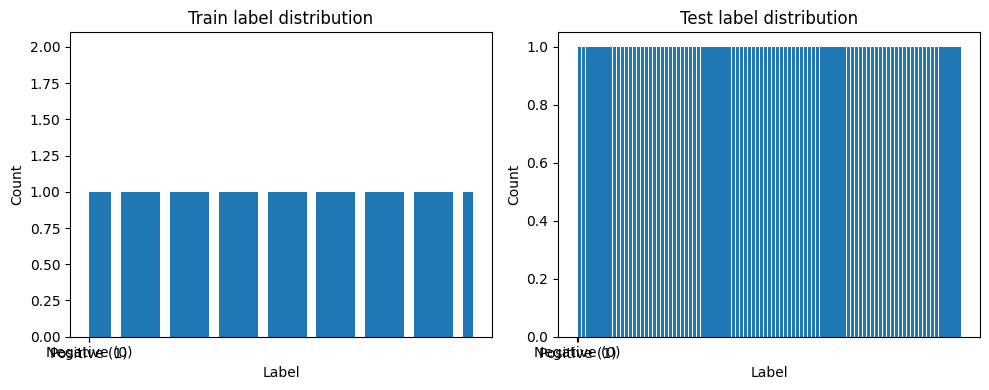

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot TRAIN distribution
train_counts = train['label'].value_counts().sort_index()
ax[0].bar(train_counts.index.astype(str), train_counts.values)
ax[0].set_title("Train label distribution")
ax[0].set_xlabel("Label")
ax[0].set_ylabel("Count")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Negative (0)', 'Positive (1)'], rotation=0)

# Plot TEST distribution
test_counts = test['label'].value_counts().sort_index()
ax[1].bar(test_counts.index.astype(str), test_counts.values)
ax[1].set_title("Test label distribution")
ax[1].set_xlabel("Label")
ax[1].set_ylabel("Count")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Negative (0)', 'Positive (1)'], rotation=0)

plt.tight_layout()
plt.show()


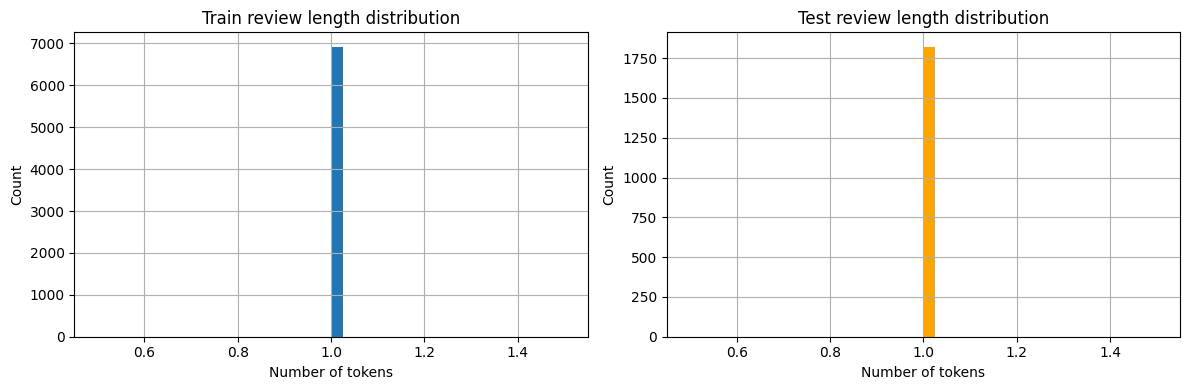

Train length stats:
 count    6920.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: length, dtype: float64

Test length stats:
 count    1821.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: length, dtype: float64


In [ ]:
# Sentence / review length (number of tokens) for train & test
train['length'] = train['text'].apply(lambda x: len(str(x).split()))
test['length'] = test['text'].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
train['length'].hist(bins=40, ax=ax[0])
ax[0].set_title("Train review length distribution")
ax[0].set_xlabel("Number of tokens")
ax[0].set_ylabel("Count")

test['length'].hist(bins=40, ax=ax[1], color="orange")
ax[1].set_title("Test review length distribution")
ax[1].set_xlabel("Number of tokens")
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

print("Train length stats:\n", train['length'].describe())
print("\nTest length stats:\n", test['length'].describe())


In [ ]:
print("Label counts in train:")
print(train['label'].value_counts())


Label counts in train:
label
0 every joke is repeated at least four times .                                                                                                                          2
0 too bad .                                                                                                                                                             2
1 ` stock up on silver bullets for director neil marshall 's intense freight train of a film . '                                                                        2
1 i like it .                                                                                                                                                           2
0 ... a pretentious mess ...                                                                                                                                            2
                                                                                                                         

In [ ]:
from sklearn.model_selection import train_test_split

X = train['text']
y = train['label']

print("Label counts before split:")
print(y.value_counts())

# If we have at least 2 samples of each class, we can stratify
if y.value_counts().min() >= 2:
    stratify_arg = y
    print("\nUsing stratified split.")
else:
    stratify_arg = None
    print("\n⚠️ Not enough samples in at least one class. Using non-stratified split.")

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_arg
)

print("\nTrain size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("\nLabel counts in TRAIN:")
print(y_train.value_counts())
print("\nLabel counts in VAL:")
print(y_val.value_counts())


Label counts before split:
label
0 every joke is repeated at least four times .                                                                                                                          2
0 too bad .                                                                                                                                                             2
1 ` stock up on silver bullets for director neil marshall 's intense freight train of a film . '                                                                        2
1 i like it .                                                                                                                                                           2
0 ... a pretentious mess ...                                                                                                                                            2
                                                                                                                     

## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Saving Amazon_Unlocked_Mobile.csv.zip to Amazon_Unlocked_Mobile.csv (2).zip
Uploaded files: dict_keys(['Amazon_Unlocked_Mobile.csv (2).zip'])
Loaded file: Amazon_Unlocked_Mobile.csv (2).zip
Columns in dataset: ['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews', 'Review Votes']


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


✅ Using text column: Reviews
Sample size: (5000, 6)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Nokia C3 (C3-00) WHITE Unlocked Phone,Nokia,59.95,2,I needed a texting phone that did not require ...,1.0
1,"Apple iPhone 6S Plus Unlocked Smartphone, 32 G...",Apple,749.99,5,Excellent!,0.0
2,Samsung Galaxy Note 3 N9005 Unlocked Cellphone...,Samsung,325.16,5,I recommend this excellent team for the many d...,0.0
3,BLU Dash L Unlocked Smartphone - Global GSM - ...,BLU,49.99,5,updated review. Purchased this phone on Novemb...,5.0
4,"LG G3 D855 Factory Unlocked Cellphone, Interna...",LG,195.99,3,battery fail,0.0


Review length stats:
count    5000.000000
mean       42.255800
std        87.910475
min         1.000000
25%         5.000000
50%        18.000000
75%        43.000000
max      1926.000000
Name: length, dtype: float64


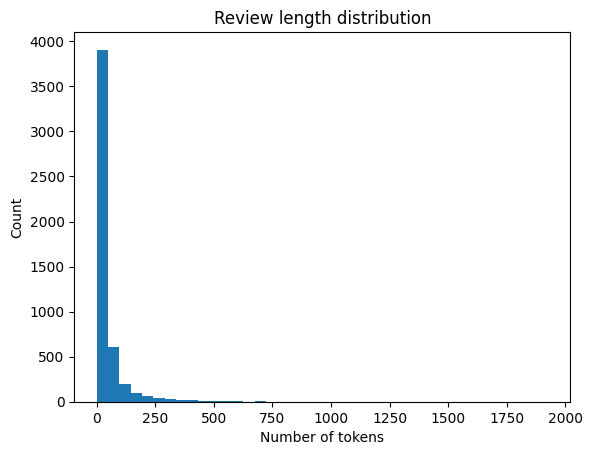

Example reviews:

[0] I needed a texting phone that did not require a data plan. I also needed a Nokia as they have the best antenna and can get out when other cell phones can't. Buyer beware! This phone is very difficult to use. It locks after a few seconds of non-use and that can't be turned off! The screen goes dark after only a few seconds of non-use and that too can not be changed. It literally took hours to figure out how to use this phone. An example: I needed to find the call log. After searching forever I finally stumbled across it under contacts. Now that makes sense, why didn't I think of that. The same problem occurred when trying to change the ring tone. Don't bother looking under settings. The only good thing about the phone is that it does get out almost everywhere. And..... no data plan required.

[1] Excellent!

[2] I recommend this excellent team for the many differentiating factors of competition, the screen, the durability of the battery, the S Pen and among others 

,clean
0,needed texting phone require data plan also ne...
1,excellent
2,recommend excellent team many differentiating ...
3,updated review purchased phone november worked...
4,battery fail


TF-IDF shape: (5000, 2183)
SVD-reduced shape: (5000, 50)
KMeans (TF-IDF) cluster counts:
kmeans_cluster
0    4197
2     241
3     205
1     197
4     160
Name: count, dtype: int64

Top terms per cluster for KMeans-TFIDF:

Cluster 0:
phone, work, great, good, like, one, nice, battery, perfect, use

Cluster 1:
love, phone, great, easy, daughter, bought, color, new, look, much

Cluster 2:
good, phone, product, price, work, far, thanks, really, fast, fine

Cluster 3:
great, phone, work, price, product, buy, problem, good, quality, like

Cluster 4:
excellent, product, phone, recommended, recommend, price, condition, smartphone, seller, love


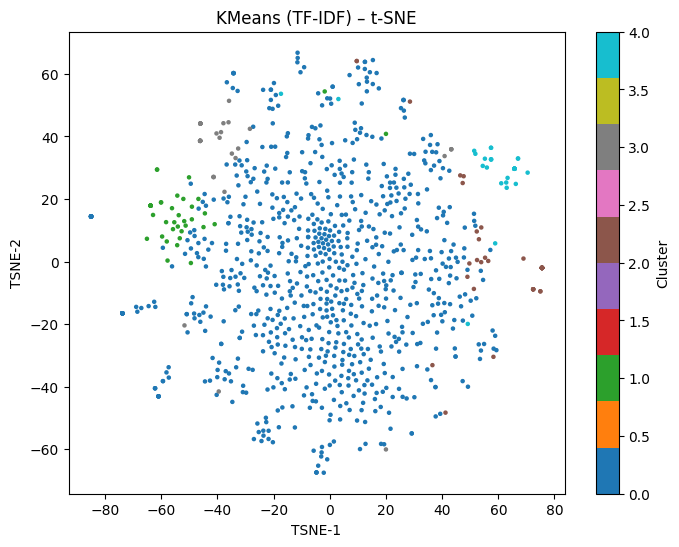

DBSCAN cluster counts (−1 = noise):
dbscan_cluster
0    5000
Name: count, dtype: int64


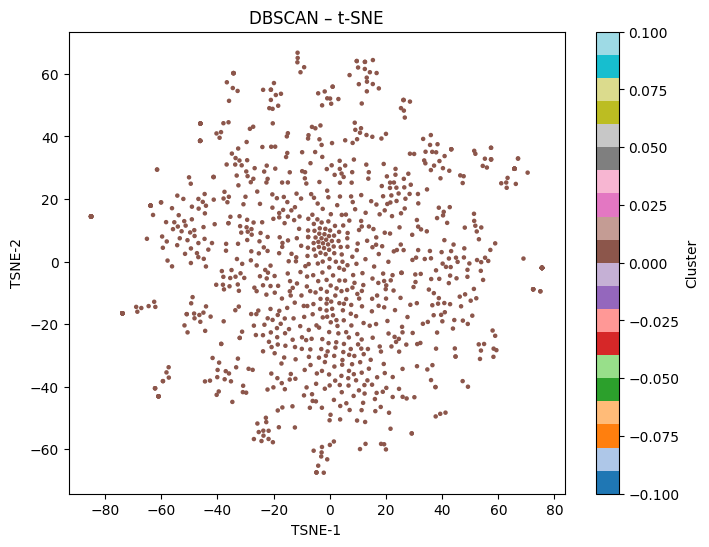

Agglomerative cluster counts:
agg_cluster
0    4514
2     161
3     149
1     107
4      69
Name: count, dtype: int64


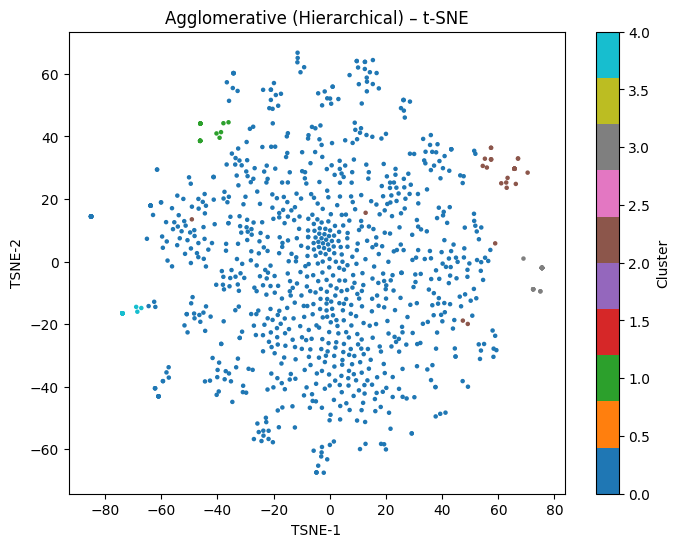

Word2Vec embeddings shape: (5000, 100)
Word2Vec + KMeans cluster counts:
w2v_cluster
4    1712
0    1447
1    1381
3     316
2     144
Name: count, dtype: int64


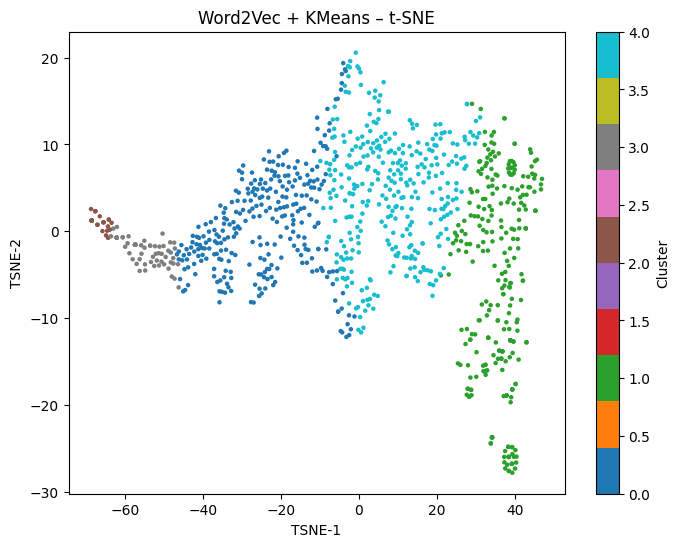

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

BERT embeddings shape: (5000, 384)
BERT + KMeans cluster counts:
bert_cluster
4    1807
2    1523
0    1107
1     348
3     215
Name: count, dtype: int64


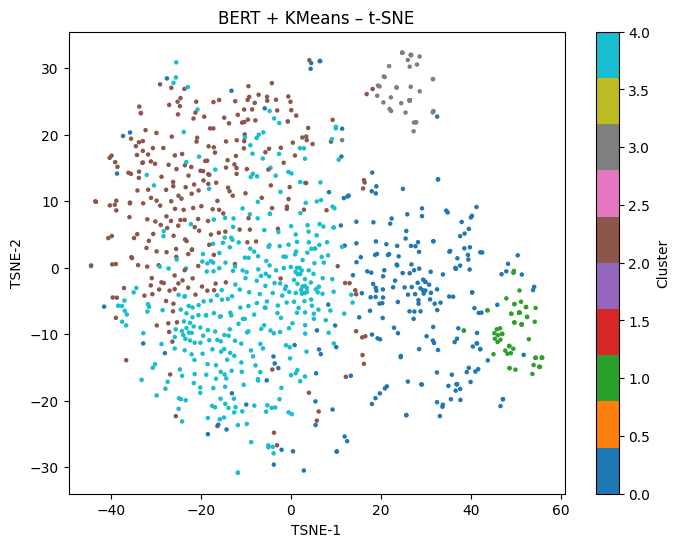


=== Examples from kmeans_cluster cluster 0 ===

[0] I needed a texting phone that did not require a data plan. I also needed a Nokia as they have the best antenna and can get out when other cell phones can't. Buyer beware! This phone is very difficult to use. It locks after a few seconds of non-use and that can't be turned off! The screen goes dark after only a few seconds of non-use and that too can not be changed. It literally took hours to figure out how to use this phone. An example: I needed to find the call log. After searching forever I finally stumbled across it under contacts. Now that makes sense, why didn't I think of that. The same problem occurred when trying to change the ring tone. Don't bother looking under settings. The only good thing about the phone is that it does get out almost everywhere. And..... no data plan required.

[2] I recommend this excellent team for the many differentiating factors of competition, the screen, the durability of the battery, the S Pen an

In [ ]:
# ============================================
# Q3 – TEXT CLUSTERING (FULL COMBINED CODE)
# ============================================

# ---------- CELL 1: Install & Imports ----------
!pip install gensim sentence-transformers -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer

nltk.download('stopwords')
nltk.download('wordnet')

# ---------- CELL 2: Upload & Load Dataset ----------
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", uploaded.keys())

# Use uploaded CSV file (first one)
csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)
print("Loaded file:", csv_name)
print("Columns in dataset:", df.columns.tolist())
display(df.head())

# ---------- CELL 3: Detect Text Column & Create Sample ----------
# Try to auto-detect the review text column name
possible_cols = [
    'Reviews', 'Review', 'review', 'reviewText', 'Review Text',
    'Body', 'Text', 'text', 'Content', 'Review_Body'
]

text_col = None
for col in possible_cols:
    if col in df.columns:
        text_col = col
        break

if text_col is None:
    raise ValueError("❌ No text review column found. Please update text_col manually.")

print("✅ Using text column:", text_col)

# Drop missing reviews and sample subset (for speed)
df = df.dropna(subset=[text_col])
df_sample = df.sample(5000, random_state=42).reset_index(drop=True)
print("Sample size:", df_sample.shape)

display(df_sample.head())

# ---------- CELL 4: Basic EDA ----------
# Length of each review
df_sample['length'] = df_sample[text_col].astype(str).apply(lambda x: len(x.split()))
print("Review length stats:")
print(df_sample['length'].describe())

plt.hist(df_sample['length'], bins=40)
plt.title("Review length distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Count")
plt.show()

print("Example reviews:")
for i in range(3):
    print(f"\n[{i}] {df_sample[text_col].iloc[i]}")

# ---------- CELL 5: Text Cleaning ----------
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = []
    for w in text.split():
        if w in stop_words:
            continue
        lemma = lemmatizer.lemmatize(w)
        tokens.append(lemma)
    return " ".join(tokens)

df_sample['clean'] = df_sample[text_col].apply(clean_text)
display(df_sample[['clean']].head())

# ---------- CELL 6: TF-IDF Features ----------
tfidf = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.8
)

X_tfidf = tfidf.fit_transform(df_sample['clean'])
print("TF-IDF shape:", X_tfidf.shape)

# Also precompute SVD-reduced version for clustering/TSNE
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_tfidf)
print("SVD-reduced shape:", X_svd.shape)

terms = np.array(tfidf.get_feature_names_out())

# Helper to show top words per centroid
def print_top_terms_per_cluster(model, n_terms=10, name="model"):
    centers = model.cluster_centers_
    print(f"\nTop terms per cluster for {name}:")
    for i in range(centers.shape[0]):
        center = centers[i]
        top_idx = center.argsort()[::-1][:n_terms]
        top_terms = terms[top_idx]
        print(f"\nCluster {i}:")
        print(", ".join(top_terms))

# Helper for TSNE scatter
def plot_tsne(X, labels, title, cmap='tab10'):
    tsne = TSNE(n_components=2, random_state=42, perplexity=40)
    X_2d = tsne.fit_transform(X)

    plt.figure(figsize=(8,6))
    sc = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=5, cmap=cmap)
    plt.title(title)
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.colorbar(sc, label="Cluster")
    plt.show()

# ---------- CELL 7: K-Means (TF-IDF) ----------
k = 5  # number of clusters (you can tune this)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_sample['kmeans_cluster'] = kmeans.fit_predict(X_tfidf)

print("KMeans (TF-IDF) cluster counts:")
print(df_sample['kmeans_cluster'].value_counts())

print_top_terms_per_cluster(kmeans, n_terms=10, name="KMeans-TFIDF")

# Visualize with TSNE (using 1000-point subset for speed)
subset_size = 1000
X_svd_sub = X_svd[:subset_size]
labels_kmeans_sub = df_sample['kmeans_cluster'][:subset_size]

plot_tsne(X_svd_sub, labels_kmeans_sub, "KMeans (TF-IDF) – t-SNE", cmap='tab10')

# ---------- CELL 8: DBSCAN (on SVD-reduced TF-IDF) ----------
dbscan = DBSCAN(eps=1.2, min_samples=10, metric='euclidean')
df_sample['dbscan_cluster'] = dbscan.fit_predict(X_svd)

print("DBSCAN cluster counts (−1 = noise):")
print(df_sample['dbscan_cluster'].value_counts())

# Visualize DBSCAN clusters
labels_dbscan_sub = df_sample['dbscan_cluster'][:subset_size]
plot_tsne(X_svd_sub, labels_dbscan_sub, "DBSCAN – t-SNE", cmap='tab20')

# ---------- CELL 9: Agglomerative (Hierarchical) Clustering ----------
h_k = 5  # number of clusters

agg = AgglomerativeClustering(n_clusters=h_k)
df_sample['agg_cluster'] = agg.fit_predict(X_svd)

print("Agglomerative cluster counts:")
print(df_sample['agg_cluster'].value_counts())

labels_agg_sub = df_sample['agg_cluster'][:subset_size]
plot_tsne(X_svd_sub, labels_agg_sub, "Agglomerative (Hierarchical) – t-SNE", cmap='tab10')

# ---------- CELL 10: Word2Vec + KMeans ----------
# Prepare tokenized sentences
sentences = [row.split() for row in df_sample['clean']]

w2v_model = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4
)

def sentence_vector(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

embeddings_w2v = np.vstack([
    sentence_vector(s, w2v_model, dim=100) for s in sentences
])
print("Word2Vec embeddings shape:", embeddings_w2v.shape)

k_w2v = 5
kmeans_w2v = KMeans(n_clusters=k_w2v, random_state=42, n_init=10)
df_sample['w2v_cluster'] = kmeans_w2v.fit_predict(embeddings_w2v)

print("Word2Vec + KMeans cluster counts:")
print(df_sample['w2v_cluster'].value_counts())

# Visualize Word2Vec + KMeans
emb_w2v_sub = embeddings_w2v[:subset_size]
labels_w2v_sub = df_sample['w2v_cluster'][:subset_size]
plot_tsne(emb_w2v_sub, labels_w2v_sub, "Word2Vec + KMeans – t-SNE", cmap='tab10')

# ---------- CELL 11: BERT (SentenceTransformer) + KMeans ----------
# This may take a few minutes depending on data size
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

sentences_bert = df_sample['clean'].tolist()
embeddings_bert = bert_model.encode(
    sentences_bert,
    batch_size=64,
    show_progress_bar=True
)
embeddings_bert = np.array(embeddings_bert)
print("BERT embeddings shape:", embeddings_bert.shape)

k_bert = 5
kmeans_bert = KMeans(n_clusters=k_bert, random_state=42, n_init=10)
df_sample['bert_cluster'] = kmeans_bert.fit_predict(embeddings_bert)

print("BERT + KMeans cluster counts:")
print(df_sample['bert_cluster'].value_counts())

# Visualize BERT + KMeans
emb_bert_sub = embeddings_bert[:subset_size]
labels_bert_sub = df_sample['bert_cluster'][:subset_size]
plot_tsne(emb_bert_sub, labels_bert_sub, "BERT + KMeans – t-SNE", cmap='tab10')

# ---------- CELL 12: Inspect Example Reviews from Clusters (Optional) ----------
def show_cluster_examples(label_col, cluster_id, n=5):
    print(f"\n=== Examples from {label_col} cluster {cluster_id} ===")
    subset = df_sample[df_sample[label_col] == cluster_id].head(n)
    for i, row in subset.iterrows():
        print(f"\n[{i}] {row[text_col]}")

# Example usage:
show_cluster_examples('kmeans_cluster', 0, n=5)
show_cluster_examples('w2v_cluster', 0, n=5)
show_cluster_examples('bert_cluster', 0, n=5)


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

Across the different clustering methods, the results varied in terms of structure, interpretability, and semantic quality. K-Means using TF-IDF produced clear and reasonably well-separated clusters based on keyword similarities, making it the most interpretable method, although it depended heavily on choosing the right number of clusters. DBSCAN behaved differently by identifying a few dense clusters and labeling many scattered reviews as noise, which made it good for detecting outliers but resulted in highly uneven cluster sizes. Hierarchical (Agglomerative) clustering revealed a multilevel topic structure, showing how broad themes split into subtopics, but some groups overlapped due to similarity in high-dimensional text data. Word2Vec + K-Means generated more semantically coherent clusters because it captured deeper relationships between words, grouping reviews that expressed similar ideas even when using different vocabulary. BERT embeddings produced the richest and most meaningful clusters overall, as it captured context, tone, and semantics far better than other methods, although the clusters were sometimes harder to label because they were based on abstract meaning rather than simple keywords. Overall, TF-IDF K-Means was the most interpretable, DBSCAN was best for detecting anomalies, hierarchical clustering exposed structural relationships, Word2Vec improved semantic grouping, and BERT delivered the most context-aware and human-like clusters.

.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**

